In [5]:
# Usual suspect
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
import functools
import math
from fastprogress import progress_bar
from typing import List
import os
sys.path.insert(1, '../muograph/')

# POCA re-weighting

Ahbishek proposed the following idea: can we re-weight the POCA point using the scattering angle distribution's standard deviation $\sigma_{\Delta\theta}$?



In [6]:
from volume.Volume_Interest import VolumeInterest
VOI = VolumeInterest(position = [0,0,835],dimension=[400,1000,300],voxel_width=20)

from analysis.analysis import analysis
my_analysis = analysis(VOI=VOI,
                       compute_tracks=True,
                       n_event=100000,
                       input_dir = "../data/MuoscopeStatue_4Scale_1-2-2016_5M_Bronze_Scattering/G4_data/",
                       output_dir = "../data/MuoscopeStatue_4Scale_1-2-2016_5M_Bronze_Scattering/test_10k/")

my_analysis.poca_setup()


Tracking in progress


Tracking done
Scattering angles computation done

Total # event =  100000
# event after removing low theta events =  42742



Assigning voxel to each POCA point:


DONE


## 1 - Score list

Score list is list which will host the scattering angles of pocas within each voxel. It is a nested list with size (Nx,Ny,Nz,Npoca) where Ni is the number of voxels along the i direction and Npoca the number of poca points within the voxel i,j,k.

In [17]:
score_list = torch.zeros((VOI.n_vox_xyz[0],
                                 VOI.n_vox_xyz[1],
                                 VOI.n_vox_xyz[2])).tolist()

for i in range(VOI.n_vox_xyz[0]):
    for j in range(VOI.n_vox_xyz[1]):
        for k in range(VOI.n_vox_xyz[2]):
            score_list[i][j][k]=[]
            
len(score_list), len(score_list[0]), len(score_list[1])

(20, 50, 50)

# 2 - Filling score list

For each voxel and each poca point, fill score list. Also computes n_poca_per_vox, the numner of poca points per voxel.

In [18]:
# load POCA if already save
poca = my_analysis.load_pickle("poca_class")

# run poca if not
# my_analysis.poca_setup()

In [19]:
from fastprogress import progress_bar
for ev in progress_bar(range(len(poca.POCA_points))):
    i,j,k = int(poca.indices[ev][0]), int(poca.indices[ev][1]), int(poca.indices[ev][2])
    score_list[i][j][k].append(poca.tracks.dtheta[ev])

std_voxel_wise = torch.zeros((VOI.n_vox_xyz[0],
                                 VOI.n_vox_xyz[1],
                                 VOI.n_vox_xyz[2]))

n_poca_per_vox = torch.zeros((VOI.n_vox_xyz[0],
                                 VOI.n_vox_xyz[1],
                                 VOI.n_vox_xyz[2]))

## 3 - Computing standard deviation

For each voxel, compute the standard deviation of the scattering angles, only if the list is not empty.

In [25]:
for i in range(VOI.n_vox_xyz[0]):
    for j in range(VOI.n_vox_xyz[1]):
        for k in range(VOI.n_vox_xyz[2]):
            
            n_poca_per_vox[i,j,k] = len(score_list[i][j][k])
            
            if(len(score_list[i][j][k])>0):
                std_voxel_wise[i,j,k] = np.std(score_list[i][j][k])

## 4 - Plot

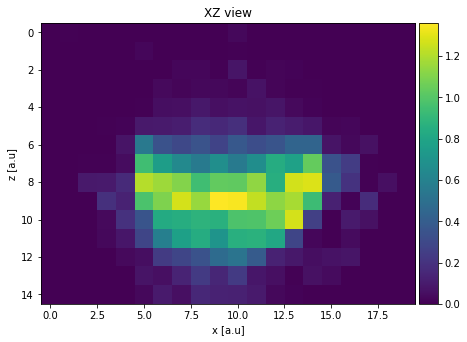

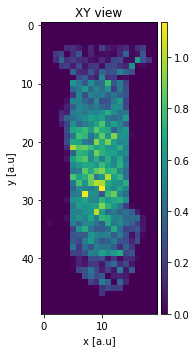

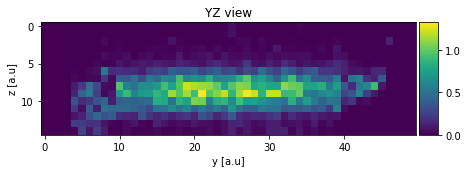

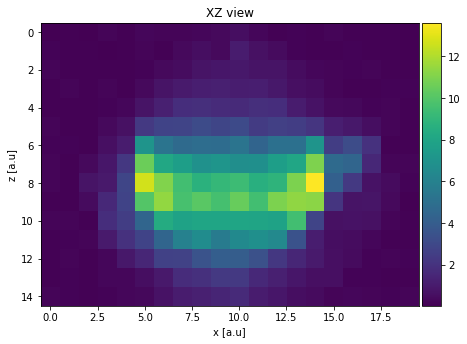

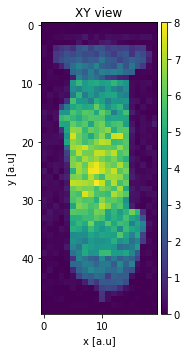

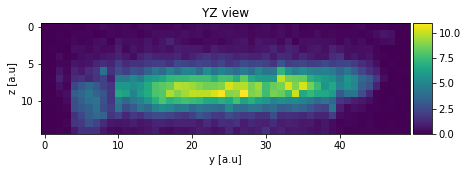

In [27]:
def normalize(tens:torch.tensor) -> torch.tensor:
    
    return (tens - torch.min(tens))/ (torch.max(tens) - torch.min(tens))

from plotting.Plotting import plot_VOI_pred

# plot_VOI_pred(normalize(std_voxel_wise))
plot_VOI_pred(n_poca_per_vox*normalize(std_voxel_wise),filename="../data/weighted")
plot_VOI_pred(n_poca_per_vox,filename="../data/not_weighted")

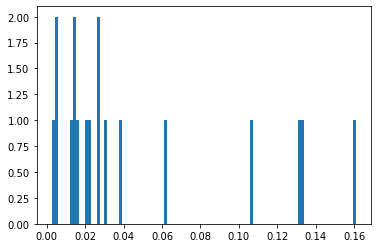

(18, 0.04919944873538903)

In [28]:
my_list = score_list[10][25][8]

plt.hist(score_list[10][25][8],bins=100)
plt.show()

len(score_list[10][25][8]), np.std(score_list[10][25][8])